# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом  разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. На основе исторические данные необходимо построить модель для определения стоимости автомобиля.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Цель:
Разработка системы рекомендации стоимости автомобиля на основе его описания

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
import time

In [ ]:
data=pd.read_csv('/datasets/autos.csv')

In [ ]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
data['DateCreated'] = pd.to_datetime(data['DateCreated'])
data['LastSeen'] = pd.to_datetime(data['LastSeen'])

In [ ]:
# data['RegistrationYear'] = pd.Categorical(data['RegistrationYear'])
# data['RegistrationMonth'] = pd.Categorical(data['RegistrationMonth'])

In [ ]:
# Преобразование названий всех столбцов в нижний регистр
data.columns = data.columns.str.lower()

# Проверка результатов
print(data.columns)

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        354369 non-null  datetime64[ns]
 1   price              354369 non-null  int64         
 2   vehicletype        316879 non-null  object        
 3   registrationyear   354369 non-null  int64         
 4   gearbox            334536 non-null  object        
 5   power              354369 non-null  int64         
 6   model              334664 non-null  object        
 7   kilometer          354369 non-null  int64         
 8   registrationmonth  354369 non-null  int64         
 9   fueltype           321474 non-null  object        
 10  brand              354369 non-null  object        
 11  repaired           283215 non-null  object        
 12  datecreated        354369 non-null  datetime64[ns]
 13  numberofpictures   354369 non-null  int64   

In [ ]:
data.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [ ]:
# Определение явных дубликатов
duplicates = data.duplicated()

# Подсчет количества явных дубликатов
num_duplicates = duplicates.sum()
print(f"Количество явных дубликатов в данных: {num_duplicates}")


Количество явных дубликатов в данных: 4


In [ ]:

# Удаление дубликатов, если они есть
if num_duplicates > 0:
    data.drop_duplicates(inplace=True)
    print("Дубликаты были удалены.")
else:
    print("Дубликатов не обнаружено.")

Дубликаты были удалены.


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        354365 non-null  datetime64[ns]
 1   price              354365 non-null  int64         
 2   vehicletype        316875 non-null  object        
 3   registrationyear   354365 non-null  int64         
 4   gearbox            334532 non-null  object        
 5   power              354365 non-null  int64         
 6   model              334660 non-null  object        
 7   kilometer          354365 non-null  int64         
 8   registrationmonth  354365 non-null  int64         
 9   fueltype           321470 non-null  object        
 10  brand              354365 non-null  object        
 11  repaired           283211 non-null  object        
 12  datecreated        354365 non-null  datetime64[ns]
 13  numberofpictures   354365 non-null  int64   

In [ ]:
# Удаление столбцов 'DateCrawled', 'DateCreated' и 'LastSeen'
data.drop(columns=['datecreated', 'lastseen','numberofpictures'], inplace=True)

In [ ]:
data['fueltype'].fillna('other', inplace=True)
data['vehicletype'].fillna('other', inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        354365 non-null  datetime64[ns]
 1   price              354365 non-null  int64         
 2   vehicletype        354365 non-null  object        
 3   registrationyear   354365 non-null  int64         
 4   gearbox            334532 non-null  object        
 5   power              354365 non-null  int64         
 6   model              334660 non-null  object        
 7   kilometer          354365 non-null  int64         
 8   registrationmonth  354365 non-null  int64         
 9   fueltype           354365 non-null  object        
 10  brand              354365 non-null  object        
 11  repaired           283211 non-null  object        
 12  postalcode         354365 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(6)
me

In [ ]:
data.describe()

,price,registrationyear,power,kilometer,registrationmonth,postalcode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,99998.000000


In [ ]:
data['gearbox'].fillna('unknown', inplace=True)

In [ ]:
data['model'].fillna('unknown', inplace=True)

In [ ]:
data['repaired'].fillna('unknown', inplace=True)

In [ ]:
data.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,postalcode
0,2016-03-24 11:52:17,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,70435
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,66954
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,90480
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437


In [ ]:
# Конвертация 'datecrawled' в формат datetime
data['datecrawled'] = pd.to_datetime(data['datecrawled'])

# Определение максимального и минимального года в 'datecrawled'
max_year_crawled = data['datecrawled'].dt.year.max()


# Фильтрация данных для исключения нереалистичных значений года регистрации
data = data[(data['registrationyear'] >= 1950) & (data['registrationyear'] <= max_year_crawled)]


# Удаление автомобилей с нереалистичными ценами
data = data[(data['price'] > 100) & (data['price'] <= 20000)]

# Удаление записей с нереалистичной мощностью
data = data[(data['power'] > 10) & (data['power'] <= 500)]


# Проверка результатов
data.describe()

,price,registrationyear,power,kilometer,registrationmonth,postalcode
count,294457.000000,294457.00000,294457.000000,294457.000000,294457.000000,294457.000000
mean,4882.296858,2002.85097,120.744462,128302.689357,6.002992,51246.025508
std,4608.957595,6.48418,53.447029,36695.275368,3.579086,25766.295744
min,101.000000,1950.00000,11.000000,5000.000000,0.000000,1067.000000
25%,1350.000000,1999.00000,77.000000,125000.000000,3.000000,30938.000000
50%,3200.000000,2003.00000,111.000000,150000.000000,6.000000,50259.000000
75%,6999.000000,2007.00000,150.000000,150000.000000,9.000000,72108.000000
max,20000.000000,2016.00000,500.000000,150000.000000,12.000000,99998.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294457 entries, 1 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        294457 non-null  datetime64[ns]
 1   price              294457 non-null  int64         
 2   vehicletype        294457 non-null  object        
 3   registrationyear   294457 non-null  int64         
 4   gearbox            294457 non-null  object        
 5   power              294457 non-null  int64         
 6   model              294457 non-null  object        
 7   kilometer          294457 non-null  int64         
 8   registrationmonth  294457 non-null  int64         
 9   fueltype           294457 non-null  object        
 10  brand              294457 non-null  object        
 11  repaired           294457 non-null  object        
 12  postalcode         294457 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(6)
me

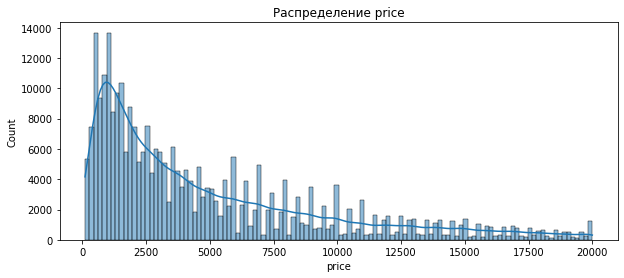

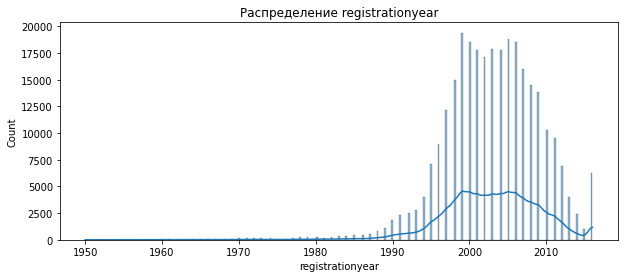

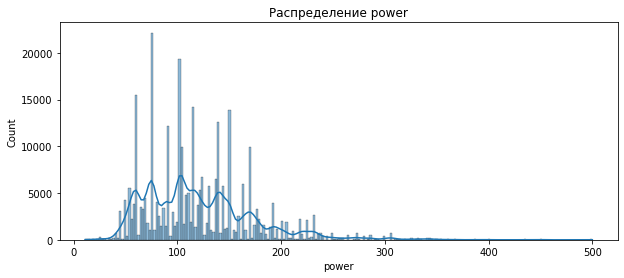

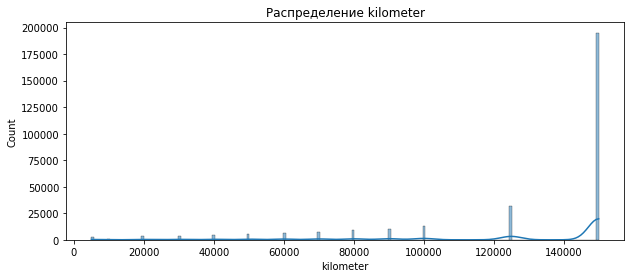

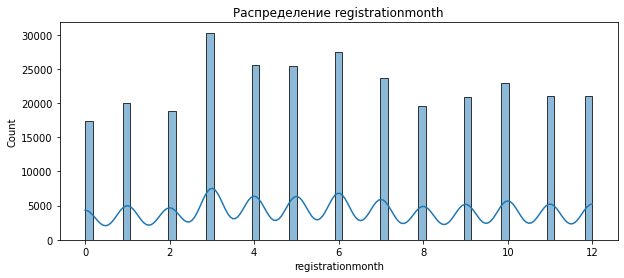

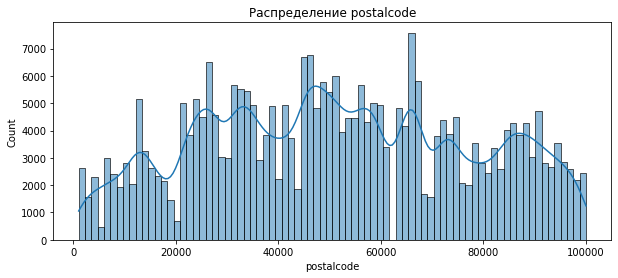

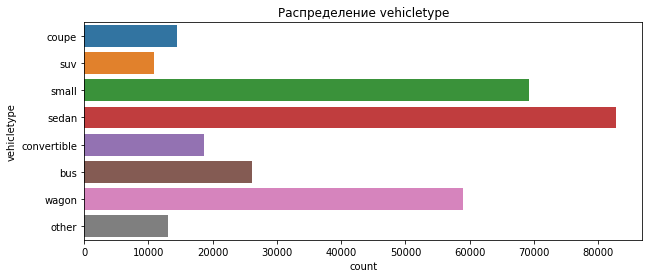

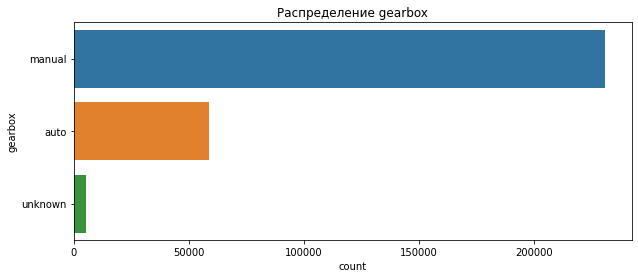

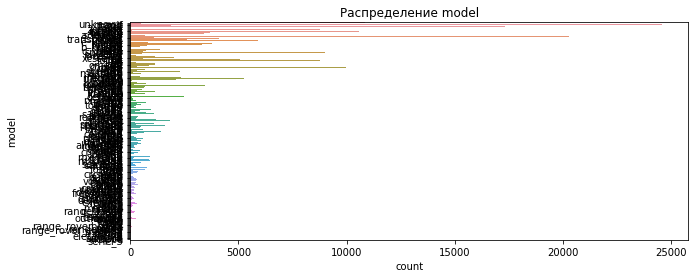

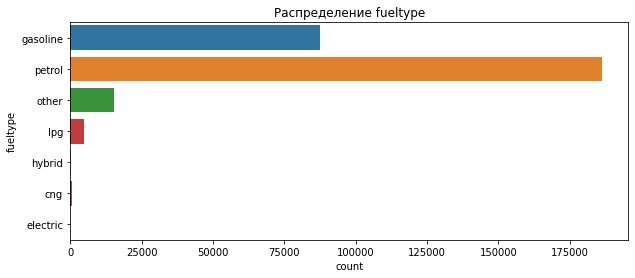

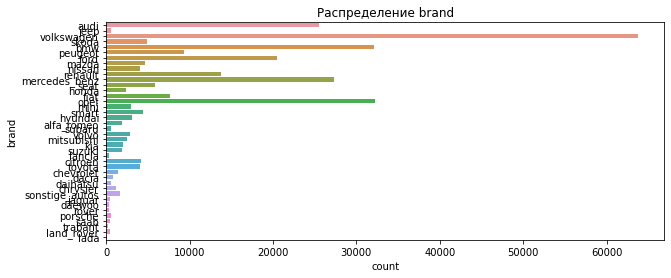

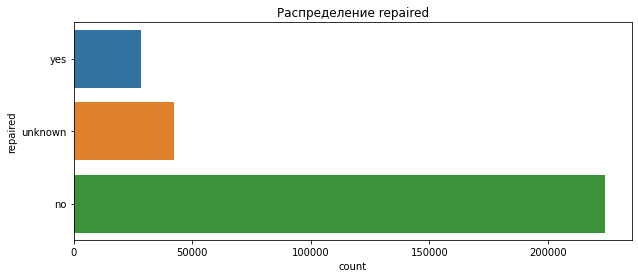

In [ ]:

# Определение числовых и категориальных столбцов
numerical_cols = data.select_dtypes(include=['int64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

# Построение графиков для числовых столбцов
for col in numerical_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(data[col], kde=True)
    plt.title(f'Распределение {col}')
    plt.show()

# Построение графиков для категориальных столбцов
for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(y=data[col])
    plt.title(f'Распределение {col}')
    plt.show()


**Вывод по разделу обзор и анализ данных:**
Был проведен обзор данных. Было обнаружено 4 явных дубликата.Они были удалены. Были удалены столбцы'datecrawled', 'datecreated', 'lastseen','numberofpictures', так как они не информативны для целей исследования. В данных было много пропущенных данных, они были заменены на 'other' и 'unknown'.  Удалены аномальные значения  в 'registrationyear', 'price','power'.

## Обучение моделей

In [ ]:
RANDOM_STATE=123

In [ ]:
# Разделение данных на признаки (X) и цель (y), исключая 'datecrawled'
X = data.drop(['price', 'datecrawled'], axis=1)
y = data['price']

# Определение категориальных и числовых столбцов
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object', 'datetime']).columns

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Создание трансформера с OneHotEncoder для категориальных и StandardScaler для числовых признаков
column_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('scaler', StandardScaler(), numerical_cols)
])

# Применение трансформации к обучающей выборке
X_train= column_transformer.fit_transform(X_train)

# Применение трансформации к тестовой выборке
X_test= column_transformer.transform(X_test)


In [ ]:


# Определение параметров для GridSearchCV
param_grid = {
    'n_estimators': [100],  #было проверено 50, из-за длительной скорости было оставлено наилучшее значение
    'max_depth': [15] #5,10
}

# Модель для подбора
rf_model = RandomForestRegressor(random_state=RANDOM_STATE)

# GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3,
                           scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Запуск GridSearchCV
%time grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f'Лучшие параметры: {best_params}')


Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 52min 12s, sys: 3.23 s, total: 52min 15s
Wall time: 52min 16s
Лучшие параметры: {'max_depth': 15, 'n_estimators': 100}


In [ ]:
# Создание модели с лучшими параметрами
best_rf_model = RandomForestRegressor(random_state=RANDOM_STATE, **best_params)

# Обучение модели
%time best_rf_model.fit(X_train, y_train)

# # Предсказание и оценка модели
# rf_predictions = best_rf_model.predict(X_test)
# rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
# print(f'RMSE случайного леса с лучшими параметрами: {rf_rmse}')

CPU times: user 18min 49s, sys: 1.27 s, total: 18min 51s
Wall time: 18min 51s


RandomForestRegressor(max_depth=15, random_state=123)

In [ ]:
# Начало измерения времени для предсказания
start_time = time.time()

# Предсказание модели
rf_predictions = best_rf_model.predict(X_test)

# Конец измерения времени для предсказания
end_time = time.time()

# Вывод времени, затраченного на предсказание
print(f"Время, затраченное на предсказания: {end_time - start_time} секунд")

# Оценка модели
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f'RMSE случайного леса с лучшими параметрами: {rf_rmse}')

Время, затраченное на предсказания: 0.8582799434661865 секунд
RMSE случайного леса с лучшими параметрами: 1629.7099946145954


In [ ]:
# Параметры для поиска
param_grid = {
    'n_estimators': [100],
    'max_depth': [10],#5
    'learning_rate': [0.1],#0.01
}

# Модель для подбора
model = LGBMRegressor(random_state=RANDOM_STATE)

# Grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)
# Получение лучших параметров
best_params = grid_search.best_params_
print(f'Лучшие параметры: {best_params}')
best_rmse = np.sqrt(-grid_search.best_score_)
print(f'Лучшие параметры: {best_params}')
print(f'Лучший RMSE: {best_rmse}')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
Лучший RMSE: 1662.5722295504397


In [ ]:
# Создание модели с лучшими параметрами
best_lgb_model = LGBMRegressor(random_state=123, **best_params)

# Измерение времени обучения модели
%time best_lgb_model.fit(X_train, y_train)


CPU times: user 27.1 s, sys: 249 ms, total: 27.4 s
Wall time: 27.6 s


LGBMRegressor(max_depth=10, random_state=123)

In [ ]:
# Начало измерения времени для предсказания
start_time = time.time()

# Предсказание модели
predictions = best_lgb_model.predict(X_test)

# Конец измерения времени для предсказания
end_time = time.time()

# Вывод времени, затраченного на предсказания
print(f"Время, затраченное на предсказания: {end_time - start_time} секунд")

# Оценка модели
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE с лучшими параметрами: {rmse}')

Время, затраченное на предсказания: 0.4907066822052002 секунд
RMSE с лучшими параметрами: 1654.87992516413


## Анализ моделей

На основе представленных результатов, можно сделать следующие выводы по моделям RandomForestRegressor и LightGBM, обученным с оптимизированными параметрами:    

Модель RandomForestRegressor:  
Время Обучения: Обучение заняло 18 минут 51 секунду, что является довольно продолжительным временем. Это указывает на высокую вычислительную нагрузку, связанную с обучением RandomForestRegressor с указанными параметрами.  
Время Предсказания: Время, затраченное на предсказания, составило 0.858 секунды, что является относительно быстрым для такого объема данных.  
RMSE: RMSE модели составила 1629.71, что указывает на довольно высокую точность предсказаний модели.
Модель LightGBM:   
Время Обучения: Обучение модели заняло 27.6 секунд, что значительно быстрее, чем у RandomForestRegressor. Это делает LightGBM предпочтительным выбором в ситуациях, где важна скорость обучения.  
Время Предсказания: Время предсказания составило 0.491 секунды, что еще быстрее, чем у RandomForestRegressor.
RMSE: RMSE модели составила 1654.88, что немного выше, чем у RandomForestRegressor, но все же показывает хорошую точность предсказаний.  
Общий Вывод:  
RandomForestRegressor обеспечивает более высокую точность предсказаний (низкий RMSE), но при этом требует значительно больше времени на обучение и имеет немного более высокое время предсказания.  
LightGBM показывает немного меньшую точность (выше RMSE), но значительно выигрывает в скорости обучения и предсказания. Это делает ее предпочтительным выбором в условиях, где время обработки данных критично и где допустима небольшая потеря в точности.  
LightGBM - при данных требованиях заказчика предпочтительнее